In [1]:
%config Completer.use_jedi = False

In [2]:
import gym
import torch
torch.manual_seed(0)

In [3]:
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
import matplotlib.pyplot as plt

In [4]:
class CartModel(nn.Module):
    def __init__(self, input_sz, hidden_sz,out):
        super().__init__()
        self.input_size=input_sz
        self.hidden_size=hidden_sz
        self.output_size=out
        self.lin1=nn.Linear(self.input_size,self.hidden_size)
        self.lin2=nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, X):
        X=torch.Tensor(X)
        out1 = F.relu(self.lin1(X))
        out2 = F.softmax(self.lin2(out1),dim=-1)
        dist=Categorical(out2)
        action=dist.sample()
        log_probs=dist.log_prob(action)
        return action.item(), log_probs
        

In [5]:
class Agent:
    def __init__(self,alpha,decay,gamma):
        self.decay=decay
        self.gamma=gamma
        self.alpha=alpha
    
    def get_gamma(self,n):
        '''
        n - number of timesteps in episodes
        Returns:
        The gamma matrix that is multiplied with the rewards to get the final return for the episode
        '''
        self.gamma_matrix = np.array([self.gamma**i for i in range(n)])
        return self.gamma_matrix
    
    def get_rewards(self,rewards):
        self.gamma_m=self.get_gamma(len(rewards))
        return float(sum(self.gamma_m*np.array(rewards)))

In [6]:
def reinforce(agent,model,env,n_episodes,steps,print_every,optimizer):
    '''
    agent - object of Agent class
    model - object of FCC model class
    env - Environment from gym.ai - in this case, it is CartPole-v0
    n_episodes - number of episodes
    steps - Since this is a continuous environment, we need to cut off the episode after specific number of steps while training. 
    This is that parameter.
    print_every - Till now, defined it within the function but will now use this as a parameter to decide after how many episodes should we give a status update 
    optimizer - Optimizer object to be used
    '''
    losses=[]
    rewards=[]
    final_score=[]
    for epi in range(1,n_episodes+1):
        reward_sum=0
        reward_epi=[]
        state=env.reset()
        log_prob_epi=[]
        for t in range(steps):
            action,log_probs=model.forward(state)
            log_prob_epi.append(log_probs)
            next_state,reward,done, info=env.step(action)
            reward_epi.append(reward)
            reward_sum+=reward
            state=next_state
            if done:
                break
        final_score.append(reward_sum)
        rewards.append(reward_sum)
        return_epi=agent.get_rewards(reward_epi)
        loss=torch.stack([return_epi*-log_prob for log_prob in log_prob_epi],dim=0).sum()
        losses.append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epi==500:
            for g in optimizer.param_groups:
                g['lr'] = 5e-4
        if epi==1500:
            for g in optimizer.param_groups:
                g['lr'] = 1e-4
        if epi%print_every==0:
            print(r'Episode:', epi, 'rewards: ',np.mean(final_score[-100:]))
        if np.mean(final_score[-100:])>=195.0:
            print('Exercise completed in ',epi,' episodes')
            break
    return rewards,losses,epi       

In [7]:
env=gym.make('CartPole-v0')
model_cart=CartModel(env.observation_space.shape[0],16,env.action_space.n)
agent=Agent(alpha=0.01, decay = 0.9999, gamma = 1)
optimizer=torch.optim.Adam(model_cart.parameters(),lr=1e-2)
print('Environment states:',env.observation_space)
print('Environment states features:',env.observation_space.shape[0])
print('Environment actions:',env.action_space)
print('Environment actions count:',env.action_space.n)                                                                

Environment states: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Environment states features: 4
Environment actions: Discrete(2)
Environment actions count: 2


In [8]:
rewards,losses,epi=reinforce(agent,model_cart,env,2500,steps=1000,print_every=100,optimizer=optimizer)

Episode: 100 rewards:  29.9
Episode: 200 rewards:  59.89
Episode: 300 rewards:  99.48
Episode: 400 rewards:  136.46
Episode: 500 rewards:  153.17
Episode: 600 rewards:  175.87
Episode: 700 rewards:  178.39
Episode: 800 rewards:  181.04
Episode: 900 rewards:  182.3
Episode: 1000 rewards:  173.56
Episode: 1100 rewards:  181.47
Episode: 1200 rewards:  181.4
Episode: 1300 rewards:  188.41
Episode: 1400 rewards:  179.79
Episode: 1500 rewards:  179.67
Episode: 1600 rewards:  186.19
Episode: 1700 rewards:  184.01
Episode: 1800 rewards:  189.2
Episode: 1900 rewards:  190.06
Episode: 2000 rewards:  190.57
Episode: 2100 rewards:  188.55
Episode: 2200 rewards:  184.64
Episode: 2300 rewards:  190.27
Episode: 2400 rewards:  189.17
Episode: 2500 rewards:  186.42


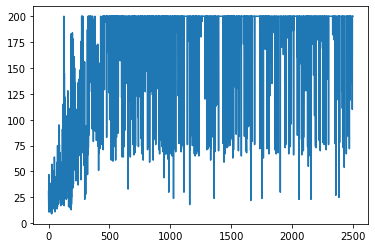

In [12]:
plt.plot(range(epi),rewards)

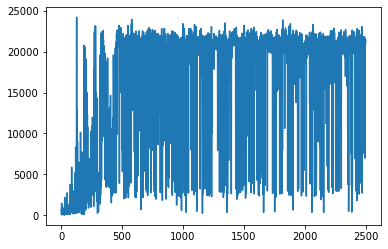

In [13]:
plt.plot(range(epi),losses)

In [22]:
torch.save(model_cart.state_dict(),'model_cart.pt')